In [29]:
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.lines as mlines
import numpy as np

In [30]:
def plot_data(X, y, ds_num):
    # Separate the points based on the labels so that we can plot the figure in a color blind friendly manner.
    X_neg = X[np.array(y) == 0]
    X_pos = X[np.array(y) == 1]
    
    # Plot the points with different markers.
    plt.scatter(X_neg[:, 0], X_neg[:, 1], c='indigo', marker='x', label='0')
    plt.scatter(X_pos[:, 0], X_pos[:, 1], c='gold', marker='o', label='1')
    
    plt.title(f"Dataset {ds_num}")
    plt.legend()
    plt.savefig(f'image/dataset_{ds_num}.jpg')
    plt.show() 

Looks separable using a linear function

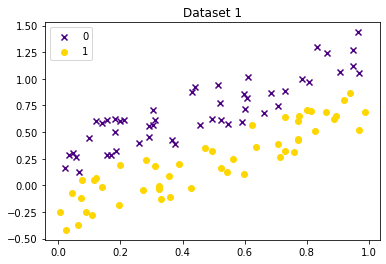

In [31]:
n_samples=100

def generate_X_lin(num_points=100, x_center=0.5, seed=42):
    np.random.seed(seed)  # Set the seed for reproducibility
    assert num_points % 2 == 0, "Number of points must be even."
    half_points = num_points // 2
    
    # Generate x-values around the center
    x_values_above = np.random.rand(half_points) + x_center - 0.5
    x_values_below = np.random.rand(half_points) + x_center - 0.5
    
    # Calculate y-values based on the linear function y = x with random noise
    y_values_above = x_values_above + np.random.rand(half_points) * 0.5
    y_values_below = x_values_below - np.random.rand(half_points) * 0.5
    
    # Combine x and y values
    X_lin_above = np.vstack((x_values_above, y_values_above)).T
    X_lin_below = np.vstack((x_values_below, y_values_below)).T
    
    return np.vstack((X_lin_above, X_lin_below))

# Generate the data
X_lin = generate_X_lin(num_points=n_samples, x_center=0.5)

y_lin_0 = [0 for _ in range(n_samples//2)]
y_lin_1 = [1 for _ in range(n_samples//2)]
y_lin = y_lin_0 + y_lin_1

plot_data(X_lin, y_lin, 1)

Looks separable using a polynomial function of degree 3

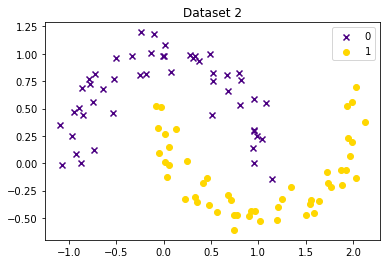

In [32]:
from sklearn.datasets import make_moons
  
X_poly, y_poly = make_moons(n_samples=100, noise=0.1) 
plot_data(X_poly, y_poly, 2)

Looks separable using a gaussian function of in 3 dimension

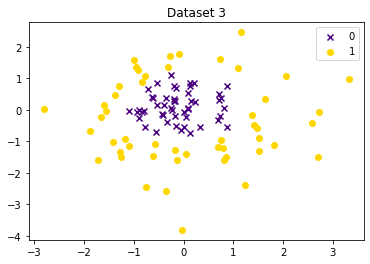

In [33]:
from sklearn.datasets import make_gaussian_quantiles 
  
X_gaus, y_gaus = make_gaussian_quantiles(n_samples=100, cov=1, n_features=2, n_classes=2, random_state=50)
plot_data(X_gaus, y_gaus, 3)

Looks separable using a tanh function

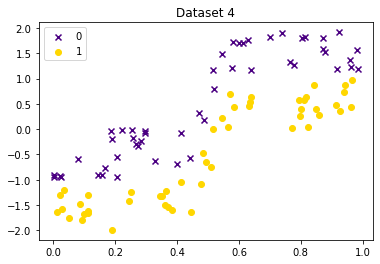

In [34]:
n_samples=100

def generate_X_tanh(num_points=100, x_center=0.5, steepness=25, seed=5): 
    np.random.seed(seed) # seed is used to not change the plot after every generation
    assert num_points % 2 == 0, "num_points must be even."
    half_points = num_points // 2
    
    # Generate x-values around the center
    x_values_above = np.random.rand(half_points) + x_center - 0.5
    x_values_below = np.random.rand(half_points) + x_center - 0.5
    
    # Calculate y-values based on the tanh function with increased steepness
    y_values_above = np.tanh(steepness * (x_values_above - x_center)) + np.random.rand(half_points) 
    y_values_below = np.tanh(steepness * (x_values_below - x_center)) - np.random.rand(half_points) 
    
    # Combine x and y values
    X_tanh_above = np.vstack((x_values_above, y_values_above)).T
    X_tanh_below = np.vstack((x_values_below, y_values_below)).T
    
    return np.vstack((X_tanh_above, X_tanh_below))

# Generate the data
X_tanh = generate_X_tanh(n_samples, x_center=0.5)

y_tanh_0 = [0 for _ in range(n_samples//2)]
y_tanh_1 = [1 for _ in range(n_samples//2)]
y_tanh = y_tanh_0 + y_tanh_1

plot_data(X_tanh, y_tanh, 4)

Get the gamma value that correspond to the value of default gamma when using sklearn SVC.
"If gamma='scale' (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma"

In [35]:
def get_gamma(train_image):
    n_features = len(train_image[0])
    gamma = 1/(train_image.var()*n_features)

    return gamma

gamma_poly = get_gamma(X_poly)
gamma_gaus = get_gamma(X_gaus)
gamma_tanh = get_gamma(X_tanh)

Define the kernel functions (default hyperparameters are used)

In [36]:
def linear_kernel(x_i, x_j):
    return np.inner(x_i, x_j)

def poly_kernel(x_i, x_j, gamma=gamma_poly, coef0=0, degree=3):
    return (gamma_poly*np.inner(x_i, x_j)+coef0)**degree

def rbf_kernel(x_i, x_j, gamma=gamma_gaus): 
    return np.exp(-gamma*np.linalg.norm(x_i-x_j))

def sigmoid_kernel(x_i, x_j, gamma=gamma_tanh, coef0=0):
    return np.tanh(gamma*np.inner(x_i, x_j)+coef0)

### Now, let's sum the cosine of angles between two data points of different labels ###
The bigger the outcome, i.e. the sum, is the smaller the angle, since cosine is a monotonically decreasing function between angle=0 and 180 degrees. This means, the classification is well-performed if the sum is small, since it means that the angles between the two data points are on average big. 

In [37]:
def sum_angl_diff_label(kernel, dataset_img, dataset_label):

    index_label_zero = []
    index_label_one = []

    # find the index of the dataset which has label 0 and label 1
    for i in range(0,100):
        if dataset_label[i] == 0:
            index_label_zero.append(i)
        else:
            index_label_one.append(i)

    inner_product_list =[]

    # calculate the inner product between data points with different labels 
    for i in index_label_zero: 
        for j in index_label_one:
            inner_product = kernel(dataset_img[i], dataset_img[j])
            normalized_inner_product = inner_product/np.sqrt(kernel(dataset_img[i], dataset_img[i])*kernel(dataset_img[j], dataset_img[j]))
            inner_product_list.append(inner_product)

    for i in index_label_one: 
        for j in index_label_zero:
            inner_product = kernel(dataset_img[i], dataset_img[j])
            normalized_inner_product = inner_product/np.sqrt(kernel(dataset_img[i], dataset_img[i])*kernel(dataset_img[j], dataset_img[j]))
            inner_product_list.append(inner_product)
            
    # we will sum the value of each inner product between two differently labeled data points 
    return sum(inner_product_list)


In [38]:
# Creating a 4x4 DataFrame
data_angl_diff_label = {
    'linear kernel': [sum_angl_diff_label(linear_kernel, X_lin, y_lin), sum_angl_diff_label(linear_kernel, X_poly, y_poly), sum_angl_diff_label(linear_kernel, X_gaus, y_gaus), sum_angl_diff_label(linear_kernel, X_tanh, y_tanh)],
    'polynomial kernel': [sum_angl_diff_label(poly_kernel, X_lin, y_lin), sum_angl_diff_label(poly_kernel, X_poly, y_poly), sum_angl_diff_label(poly_kernel, X_gaus, y_gaus), sum_angl_diff_label(poly_kernel, X_tanh, y_tanh)],
    'RBF kernel': [sum_angl_diff_label(rbf_kernel, X_lin, y_lin), sum_angl_diff_label(rbf_kernel, X_poly, y_poly), sum_angl_diff_label(rbf_kernel, X_gaus, y_gaus), sum_angl_diff_label(rbf_kernel, X_tanh, y_tanh)],
    'sigmoid kernel': [sum_angl_diff_label(sigmoid_kernel, X_lin, y_lin), sum_angl_diff_label(sigmoid_kernel, X_poly, y_poly), sum_angl_diff_label(sigmoid_kernel, X_gaus, y_gaus), sum_angl_diff_label(sigmoid_kernel, X_tanh, y_tanh)]
}
 
index_labels = ['Dataset 1', 'Dataset 2', 'Dataset 3', 'Dataset 4']
 
df_angl_diff_label = pd.DataFrame(data_angl_diff_label, index=index_labels)

print("Dataframe for sum of cosine of angle between different labeled data points:")
print(df_angl_diff_label)

Dataframe for sum of inner product between different labeled data points:
           linear kernel  polynomial kernel   RBF kernel  sigmoid kernel
Dataset 1    1909.958431        1534.615709  3710.877834     1157.761285
Dataset 2    -314.426746         137.192626  2595.133133     -206.444169
Dataset 3    -248.361620       -1064.640877  2152.352173     -109.049542
Dataset 4     -19.508370       -6065.404788  2718.949041      264.659356


Plotting the dataframe

In [39]:
# preparation for color blind friendly plots

blue_o = mlines.Line2D([], [], color='#1f77b4', marker='o',
                          markersize=8, label='linear kernel')
orange_x = mlines.Line2D([], [], color='#ff7f0e', marker='x',
                          markersize=8, label='polynomial kernel')
green_dia = mlines.Line2D([], [], color='#2ca02c', marker='D',
                          markersize=6, label='RBF kernel')
red_tri = mlines.Line2D([], [], color='#d62728', marker='^',
                          markersize=8, label='sigmoid kernel')

markers = ["o", "x", "D", "^"]

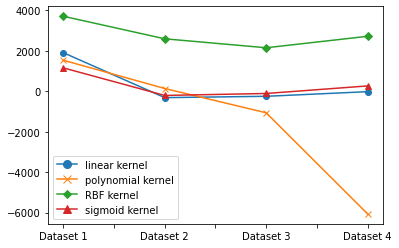

In [40]:
plot_angl_diff = df_angl_diff_label.plot.line() 

for i, line in enumerate(plot_angl_diff.get_lines()):
    line.set_marker(markers[i])

plot_angl_diff.legend(handles=[blue_o, orange_x, green_dia, red_tri])

# save figure
plot_angl_diff_1 = plot_angl_diff.figure
plot_angl_diff_1.savefig(f'image/plot_angl_diff_1.jpg')

Zooming into the plot (not necessary)

In [57]:
# plot_angl_diff.set_ylim([-2000,1000]) # disregarding some outlier 
# plot_angl_diff_2 = plot_angl_diff.figure
# plot_angl_diff_2.savefig(f'image/plot_angl_diff_2.jpg') 

### Now, let's sum the cosine of angles between two data points of the same label ###
The bigger the outcome, i.e. the sum, is the smaller the angle, since cosine is a monotonically decreasing function between angle=0 and 180 degrees. This means, the classification is well-performed if the sum is big, since it means that the angles between the two data points are on average small. 

In [42]:
def sum_angl_same_label(kernel, dataset_img, dataset_label):

    index_label_zero = []
    index_label_one = []

    # find the index of the dataset which has label 0 and label 1
    for i in range(0,100):
        if dataset_label[i] == 0:
            index_label_zero.append(i)
        else:
            index_label_one.append(i)

    inner_product_list =[]

    # calculate the inner product between data points with same label 
    for i in index_label_zero: 
        for j in index_label_zero:
            inner_product = kernel(dataset_img[i], dataset_img[j])
            normalized_inner_product = inner_product/np.sqrt(kernel(dataset_img[i], dataset_img[i])*kernel(dataset_img[j], dataset_img[j]))
            inner_product_list.append(normalized_inner_product)
            
    for i in index_label_one: 
        for j in index_label_one:
            inner_product = kernel(dataset_img[i], dataset_img[j])
            normalized_inner_product = inner_product/np.sqrt(kernel(dataset_img[i], dataset_img[i])*kernel(dataset_img[j], dataset_img[j]))
            inner_product_list.append(normalized_inner_product)

    # we will sum the value of each inner product between two same labeled data points 
    return sum(inner_product_list)

In [43]:
# Creating a 4x4 DataFrame
data_angl_same_label = {
    'linear kernel': [sum_angl_same_label(linear_kernel, X_lin, y_lin), sum_angl_same_label(linear_kernel, X_poly, y_poly), sum_angl_same_label(linear_kernel, X_gaus, y_gaus), sum_angl_same_label(linear_kernel, X_tanh, y_tanh)],
    'polynomial kernel': [sum_angl_same_label(poly_kernel, X_lin, y_lin), sum_angl_same_label(poly_kernel, X_poly, y_poly), sum_angl_same_label(poly_kernel, X_gaus, y_gaus), sum_angl_same_label(poly_kernel, X_tanh, y_tanh)],
    'RBF kernel': [sum_angl_same_label(rbf_kernel, X_lin, y_lin), sum_angl_same_label(rbf_kernel, X_poly, y_poly), sum_angl_same_label(rbf_kernel, X_gaus, y_gaus), sum_angl_same_label(rbf_kernel, X_tanh, y_tanh)],
    'sigmoid kernel': [sum_angl_same_label(sigmoid_kernel, X_lin, y_lin), sum_angl_same_label(sigmoid_kernel, X_poly, y_poly), sum_angl_same_label(sigmoid_kernel, X_gaus, y_gaus), sum_angl_same_label(sigmoid_kernel, X_tanh, y_tanh)]
}
 
index_labels = ['Dataset 1', 'Dataset 2', 'Dataset 3', 'Dataset 4']
 
df_angl_same_label = pd.DataFrame(data_angl_same_label, index=index_labels)

print("Dataframe for sum of inner product between same labeled data points:")
print(df_angl_same_label)

Dataframe for sum of inner product between same labeled data points:
           linear kernel  polynomial kernel   RBF kernel  sigmoid kernel
Dataset 1    4031.433245        3709.793459  4004.223497     4211.500736
Dataset 2    2482.787517        2083.055941  3328.183621     2777.405521
Dataset 3     204.458802         165.873949  2674.764692      219.539375
Dataset 4    1514.011486        1660.230741  3123.320834     1385.803193


Plotting the dataframe

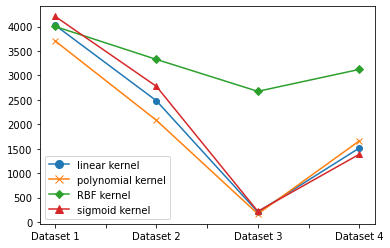

In [44]:
plot_angl_same = df_angl_same_label.plot.line() 

for i, line in enumerate(plot_angl_same.get_lines()):
    line.set_marker(markers[i])

plot_angl_same.legend(handles=[blue_o, orange_x, green_dia, red_tri])

# save figure
plot_angl_same_1=plot_angl_same.figure
plot_angl_same_1.savefig(f'image/plot_angl_same_1.jpg')

Zooming into the plot (not necessary)

In [56]:
# plot_angl_same.set_ylim([0,2000]) # disregarding some outlier 
# plot_angl_same_2 = plot_angl_same.figure
# plot_angl_same_2.savefig(f'image/plot_angl_same_2.jpg') 

### Now, let's sum the distance between two data points of different labels ###
The bigger the outcome, i.e. the sum, is the bigger the distance. This means, the classification is well-performed if the sum is big, since it means that the distance between the two data points are on average big. 

In [46]:
def sum_dis_diff_label(kernel, dataset_img, dataset_label):

    index_label_zero = []
    index_label_one = []

    # find the index of the dataset which has label 0 and label 1
    for i in range(0,100):
        if dataset_label[i] == 0:
            index_label_zero.append(i)
        else:
            index_label_one.append(i)

    distance_list =[]

    # calculate the distance**2 between data points with different labels 
    for i in index_label_zero: 
        for j in index_label_one:
            distance = (kernel(dataset_img[i], dataset_img[i])-2*kernel(dataset_img[i], dataset_img[j])+kernel(dataset_img[j], dataset_img[j]))
            distance_list.append(distance)
                        
    # we will sum the value of each distance**2 between two differently labeled data points 
    return sum(distance_list)


In [47]:
# Creating a 4x4 DataFrame
data_dis_diff_label = {
    'linear kernel': [sum_dis_diff_label(linear_kernel, X_lin, y_lin), sum_dis_diff_label(linear_kernel, X_poly, y_poly), sum_dis_diff_label(linear_kernel, X_gaus, y_gaus), sum_dis_diff_label(linear_kernel, X_tanh, y_tanh)],
    'polynomial kernel': [sum_dis_diff_label(poly_kernel, X_lin, y_lin), sum_dis_diff_label(poly_kernel, X_poly, y_poly), sum_dis_diff_label(poly_kernel, X_gaus, y_gaus), sum_dis_diff_label(poly_kernel, X_tanh, y_tanh)],
    'RBF kernel': [sum_dis_diff_label(rbf_kernel, X_lin, y_lin), sum_dis_diff_label(rbf_kernel, X_poly, y_poly), sum_dis_diff_label(rbf_kernel, X_gaus, y_gaus), sum_dis_diff_label(rbf_kernel, X_tanh, y_tanh)],
    'sigmoid kernel': [sum_dis_diff_label(sigmoid_kernel, X_lin, y_lin), sum_dis_diff_label(sigmoid_kernel, X_poly, y_poly), sum_dis_diff_label(sigmoid_kernel, X_gaus, y_gaus), sum_dis_diff_label(sigmoid_kernel, X_tanh, y_tanh)]
}
 
index_labels = ['Dataset 1', 'Dataset 2', 'Dataset 3', 'Dataset 4']
 
df_dis_diff_label = pd.DataFrame(data_dis_diff_label, index=index_labels)

print("Dataframe for sum of distance between different labeled data points:")
print(df_dis_diff_label)

Dataframe for sum of distance between different labeled data points:
           linear kernel  polynomial kernel   RBF kernel  sigmoid kernel
Dataset 1    1452.552282        4567.208807  1289.122166      685.816056
Dataset 2    7101.041791       41102.158138  2404.866867     3134.691987
Dataset 3   11355.328967      388589.738832  2847.647827     3246.950707
Dataset 4    7903.758456       54103.127993  2281.050959     2905.657497


Plotting the dataframe

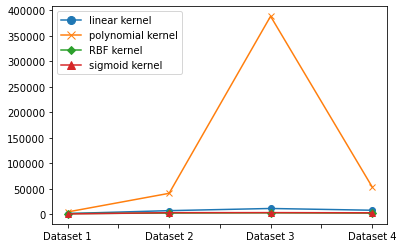

In [48]:
plot_dis_diff = df_dis_diff_label.plot.line() 

for i, line in enumerate(plot_dis_diff.get_lines()):
    line.set_marker(markers[i])

plot_dis_diff.legend(handles=[blue_o, orange_x, green_dia, red_tri])

# save figure
plot_dis_diff_1 = plot_dis_diff.figure
plot_dis_diff_1.savefig(f'image/plot_dis_diff_1.jpg')

Zooming into the plot

In [49]:
plot_dis_diff.set_ylim([0,13000]) # disregarding some outliers
plot_dis_diff_2 = plot_dis_diff.figure
plot_dis_diff_2.savefig(f'image/plot_dis_diff_2.jpg') 

### Now, let's sum the distance between two data points of the same label ###
The bigger the outcome, i.e. the sum, is the bigger the distance. This means, the classification is well-performed if the sum is small, since it means that the distance between the two data points are on average small. 

In [50]:
def sum_dis_same_label(kernel, dataset_img, dataset_label):

    index_label_zero = []
    index_label_one = []

    # find the index of the dataset which has label 0 and label 1
    for i in range(0,100):
        if dataset_label[i] == 0:
            index_label_zero.append(i)
        else:
            index_label_one.append(i)

    distance_list =[]

    # calculate the distance**2 between data points with the same label 
    for i in index_label_zero: 
        for j in index_label_zero:
            distance = kernel(dataset_img[i], dataset_img[i])-2*kernel(dataset_img[i], dataset_img[j])+kernel(dataset_img[j], dataset_img[j])
            distance_list.append(distance)
            
    for i in index_label_one: 
        for j in index_label_one:
            distance = (kernel(dataset_img[i], dataset_img[i])-2*kernel(dataset_img[i], dataset_img[j])+kernel(dataset_img[j], dataset_img[j]))
            distance_list.append(distance)

    # we will sum the value of each distance**2 between two same labeled data points 
    return sum(distance_list)

In [51]:
# Creating a 4x4 DataFrame
data_dis_same_label = {
    'linear kernel': [sum_dis_same_label(linear_kernel, X_lin, y_lin), sum_dis_same_label(linear_kernel, X_poly, y_poly), sum_dis_same_label(linear_kernel, X_gaus, y_gaus), sum_dis_same_label(linear_kernel, X_tanh, y_tanh)],
    'polynomial kernel': [sum_dis_same_label(poly_kernel, X_lin, y_lin), sum_dis_same_label(poly_kernel, X_poly, y_poly), sum_dis_same_label(poly_kernel, X_gaus, y_gaus), sum_dis_same_label(poly_kernel, X_tanh, y_tanh)],
    'RBF kernel': [sum_dis_same_label(rbf_kernel, X_lin, y_lin), sum_dis_same_label(rbf_kernel, X_poly, y_poly), sum_dis_same_label(rbf_kernel, X_gaus, y_gaus), sum_dis_same_label(rbf_kernel, X_tanh, y_tanh)],
    'sigmoid kernel': [sum_dis_same_label(sigmoid_kernel, X_lin, y_lin), sum_dis_same_label(sigmoid_kernel, X_poly, y_poly), sum_dis_same_label(sigmoid_kernel, X_gaus, y_gaus), sum_dis_same_label(sigmoid_kernel, X_tanh, y_tanh)]
}
 
index_labels = ['Dataset 1', 'Dataset 2', 'Dataset 3', 'Dataset 4']
 
df_dis_same_label = pd.DataFrame(data_dis_same_label, index=index_labels)

print("Dataframe for sum of distance between same labeled data points:")
print(df_dis_same_label)

Dataframe for sum of distance between same labeled data points:
           linear kernel  polynomial kernel   RBF kernel  sigmoid kernel
Dataset 1    1883.903150        7514.785887  1991.553007      794.925000
Dataset 2    6478.856479       51259.239187  3343.632758     2558.906544
Dataset 3   21324.516098      748112.530072  4650.470616     6016.957832
Dataset 4   10885.937311       61462.561262  3753.358332     4681.957586


Plotting the dataframe

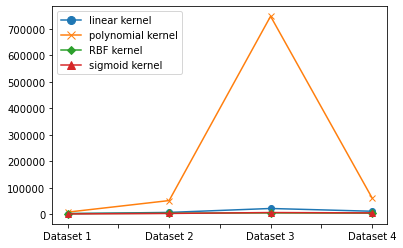

In [52]:
plot_dis_same = df_dis_same_label.plot.line()

for i, line in enumerate(plot_dis_same.get_lines()):
    line.set_marker(markers[i])

plot_dis_same.legend(handles=[blue_o, orange_x, green_dia, red_tri])

# save figure
plot_dis_same_1=plot_dis_same.figure
plot_dis_same_1.savefig(f'image/plot_dis_same_1.jpg')

Zooming into the plot

In [53]:
plot_dis_same.set_ylim([0,23000]) # disregarding some outliers
plot_dis_same_2 = plot_dis_same.figure
plot_dis_same_2.savefig(f'image/plot_dis_same_2.jpg') 